In [1]:
import pymc as pm
import numpy as np
from astropy import units as u
from astropy import constants as c
import arviz as az
from astropy.table import Table
import matplotlib.pyplot as plt
from tqdm import tqdm
import wlclusters as wlcl

## I - Loading data
### Intialize the chosen cosmology using astropy:


In [2]:
from astropy.cosmology import Planck18 as cosmo

### Load the sources and cluster catalogues:

In [3]:
sourcesHECTOMAP = Table.read('sources_HECTOMAP.fits', format='fits', memmap=True)

In [4]:
cluster_cat = Table.read('./hamana_clusters.fits', format='fits', memmap=True)

### Keeping only the subsample of clusters that fall in the sources fov (here the hectomap field)

In [5]:
ra_min = sourcesHECTOMAP['RA'].min()
ra_max = sourcesHECTOMAP['RA'].max()
dec_min = sourcesHECTOMAP['Dec'].min()
dec_max = sourcesHECTOMAP['Dec'].max()

# Filter the cluster catalogue to include only clusters within the field of view
filtered_cluster_cat = cluster_cat[
    (cluster_cat['RA'] >= ra_min) &
    (cluster_cat['RA'] <= ra_max) &
    (cluster_cat['Dec'] >= dec_min) &
    (cluster_cat['Dec'] <= dec_max)
]

## II - Profile extraction and fitting
### Defining the binning in which the extraction and the fitting will be done (in Mpc proper)

### Using the cluster catalogue and the source catalogue, the "shear_extraction" function will extract the 1D shear profile around each cluster, in a given radial range (bin_edges) and using sources at a given redshift behind the lens (dz).

In [7]:
# Extract shear profiles
shear_profiles = wlcl.shear_extraction(cluster_cat=filtered_cluster_cat, 
                                  sources=sourcesHECTOMAP, 
                                  bin_edges=bin_edges,
                                  dz=0.1,
                                  cosmo = cosmo)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.90it/s]


### We can now run the MCMC, which will return two astropy tables, one containing the posteriors of each parameter (all_chains) and one containing a wrap up of the same information: median values, 16th and 84th percentiles (results).

In [8]:
all_chains, results = wlcl.run(cluster_cat=filtered_cluster_cat, 
                 shear_profiles=shear_profiles, 
                 cosmo=cosmo)

  0%|                                                     | 0/3 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cdelt, rdelt]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
 33%|███████████████                              | 1/3 [00:25<00:50, 25.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cdelt, rdelt]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
 67%|██████████████████████████████               | 2/3 [00:46<00:22, 22.92s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cdelt, rdelt]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
100%|█████████████████████████████████████████████| 3/3 [01:07<00:00, 22.65s/it]


## III - Data visualisation 
### We can use the wldata_from_ID function to recover the shear envelopes of a given cluster thanks to its ID, here the 3 cluster have IDs 101, 102 and 103 (by using 'median parameters' instead of 'envelope' one can also return the shear profile given by the median parameters instead of the envelope):

In [9]:
wldata101, gplus_envelope101, rm101 = wlcl.wldata_from_ID(101, 
                   filtered_cluster_cat, 
                   shear_profiles, 
                   results, 
                   all_chains=all_chains,
                   return_shear=True,
                   return_shear_model='envelope', 
                   cosmo=cosmo)

wldata102, gplus_envelope102, rm102 = wlcl.wldata_from_ID(102, 
                   filtered_cluster_cat, 
                   shear_profiles, 
                   results, 
                   all_chains=all_chains,
                   return_shear=True,
                   return_shear_model='envelope', 
                   cosmo=cosmo)

wldata103, gplus_envelope103, rm103 = wlcl.wldata_from_ID(103, 
                   filtered_cluster_cat, 
                   shear_profiles, 
                   results, 
                   all_chains=all_chains,
                   return_shear=True,
                   return_shear_model='envelope', 
                   cosmo=cosmo)

100%|█████████████████████████████████████████| 500/500 [00:09<00:00, 52.40it/s]


### We can use the 16th and 84th percentiles of the envelopes as contours to be plotted:

In [13]:
contours101 = np.percentile(gplus_envelope101, [16, 84], axis=0)
contours102 = np.percentile(gplus_envelope102, [16, 84], axis=0)
contours103 = np.percentile(gplus_envelope103, [16, 84], axis=0)

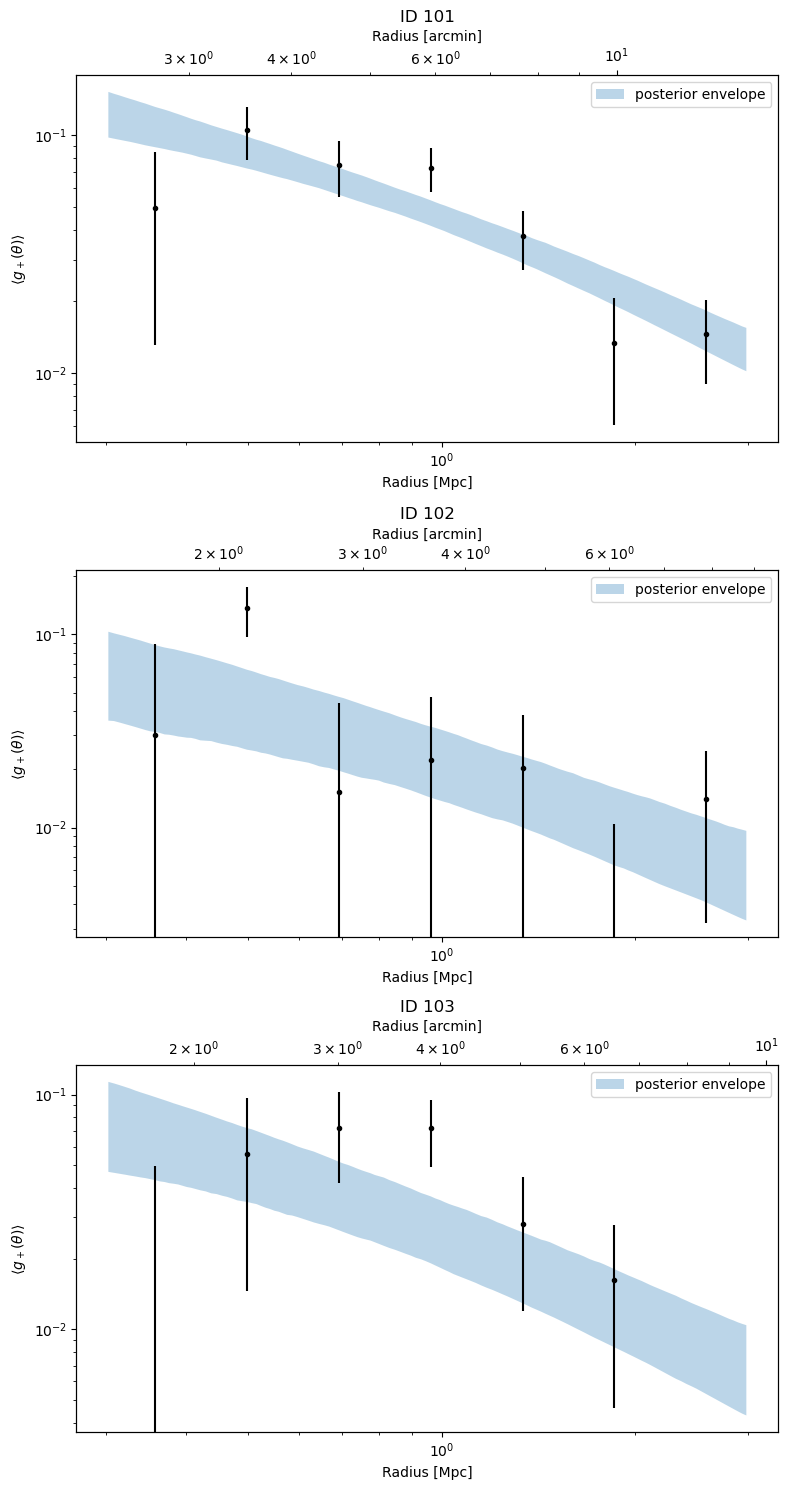

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# Function to plot each dataset
def plot_data(ax, wldata, contours, rm, title):
    ax.errorbar(wldata.rref_wl, wldata.gplus, yerr=wldata.err_gplus, fmt='.', color='black')
    ax.fill_between(rm, contours[0], contours[1], alpha=0.3, label='posterior envelope')
    ax.set_xlabel('Radius [Mpc]')
    ax.set_ylabel(r'$\langle g_+(\theta) \rangle$')
    ax.loglog()
    ax.legend()
    ax.set_title(title)

    # Add arcmin axis
    radii_arcmin = (wldata.rin_wl_am + wldata.rout_wl_am) / 2
    ax2 = ax.twiny()
    ax2.set_xscale('log')
    ax2.set_xlabel('Radius [arcmin]')
    ax2.set_xlim(min(radii_arcmin), max(radii_arcmin))

# Plot for ID 101
plot_data(axes[0], wldata101, contours101, rm101, 'ID 101')

# Plot for ID 102
plot_data(axes[1], wldata102, contours102, rm102, 'ID 102')

# Plot for ID 103
plot_data(axes[2], wldata103, contours103, rm103, 'ID 103')

plt.tight_layout()
plt.show()

In [12]:
# results.write('./results_wlcl_hectomap.fits', format='fits', overwrite=True)
# all_chains.write('./chains_wlcl_hectomap.fits', format='fits', overwrite=True)